In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [18]:
### WE CREATE A DICTIONARY OF THE TXT FILE

def H_parse_annotation(annotation_filename):
    
    fh = open(annotation_filename,"r")
    dict_annotations = {}
    
    while True:
        img_name = fh.readline().rstrip()
        if not img_name:
            break
        faces_num = int(fh.readline())
        
        dict_annotations[str(img_name)] = []
        for _ in range(faces_num):
            
            
            entry_data = [float(x) for x in fh.readline().split()]
            axis_rad_1, axis_rad_2, angle, center_x, center_y, _ = entry_data
            
            dict_annotations[img_name].append(dict([
                ('major_axis' , int(max(axis_rad_1,axis_rad_2))),
                ('minor_axis' , int(min(axis_rad_1,axis_rad_2))),
                ('angle'      , int(math.degrees(angle))),
                ('center_x'   , int(center_x)), 
                ('center_y'   , int(center_y))
            ]))
            
            
    fh.close()
    return dict_annotations


In [19]:
#Finds faces, crops them and returns a list of rectangle vertices(where the faces used to be)

def Get_faces (img, img_data,id_true):
    
    rects = []
    
    for ellps in img_data:
        #CYCLE THROUGH THE ELIPCES IN THE SELECTED IMAGE'S DICTIONARY ARRAY
        #print(ellps)
    
        center_coordinates = (ellps['center_x'], ellps['center_y'])
        axesLength = (ellps['major_axis'], ellps['minor_axis'])
        startAngle = 0
        endAngle = 360
        
            # Red color in BGR 
        red = (0, 0, 255) 
        thickness = 2
        
            # Blue color in BGR 
        blue = (255, 0, 0) 

        #error_x = int(ellps['major_axis'] * math.sin(90-ellps['angle']))
        #error_y = int(ellps['minor_axis'] * math.sin(90-ellps['angle']))
        #print("x,y: "+ str(error_x) + str(error_y))
        
            ## SET UP BOUNDING BOX
            #[l,t,r,b]
        l = int(ellps['center_x']-ellps['minor_axis'])
        t = int(ellps['center_y']-ellps['major_axis'])
        r = int(ellps['center_x']+ellps['minor_axis'])
        b = int(ellps['center_y']+ellps['major_axis'])
        
        #check bounds
        l = l if l > 0 else 0
        t = t if t > 0 else 0
        r = r if r < img.shape[1] else img.shape[1]
        b = b if b < img.shape[0] else img.shape[0]
        
        start_point = (l , t)
        end_point   = (r , b)

        ##crop FACES
        id_true += 1
        id_roi = str(id_true).zfill(4)
        roi = img[t:b,l:r]
        path = 'Faces/TrainSet/face/' 
        cv2.imwrite(path + id_roi+'.jpg',roi)

        rect = [l,t,r,b]
            
        #img = cv2.rectangle(img, start_point, end_point, blue, thickness) 
        
        
        rects.append(rect)   
    
    return (img,rects,id_true)



In [20]:

#check if origin coordinates is valid

def Check_IUO(ol,ot,w,h,rects,count):
    iuo    = 0
    iuoMax = min(0.5,0+count*0.005)
    
    for rect in rects:
        A1 = w * h
        l,t,r,b = rect
        A2 = (r-l+1)*(b-t+1)
        # li = max(l1,l2 ) ri = min(r1,r2 ) ti = max(t1,t2 ) bi = min(b1, b2 )
        li  = max(ol  ,l)
        ri  = min(ol+w,r)
        ti  = max(ot  ,t)
        bi  = min(ot+h,b)      
        Ai  = ( ri - li +1)*( bi - ti +1)
        Au  = A1+A2-Ai
        
        Au = Au if Au != 0 else 0.01
        
        iuo = Ai /Au
        
        if iuo > iuoMax:
            #print("IUO=" + str(iuo))
            return False
    
    return True
    

#Create non-faced image
import random
from datetime import datetime

def Create_empty(img, rects, id_neg):
    empties      = []
    empties_owed = []
    timeout      = 300
    i = 0
    while i < len(rects):
        l,t,r,b = rects[i]
        w    = r - l #width rect
        h    = b - t #height rect
        #[l,t,r,b]
        valid_empty = False
        
        count       = 0
        while count < timeout:
            count += 1
            maxW = img.shape[1]-w
            maxH = img.shape[0]-h
            maxW = maxW if maxW > 0 else 0
            maxH = maxH if maxH > 0 else 0
           
            random.seed(datetime.now())

            ol = random.randint(0,maxW) # 0 -> (width img - width rect)
            ot = random.randint(0,maxH) # 0 -> (height img - height rect)
            
            valid_empty = Check_IUO(ol,ot,w,h,rects, count)
           
            if valid_empty:
                count = timeout
                
        if valid_empty is False: #can't fit a negative in image
            print("NO FIT")
            empties_owed.append([ol,ot,ol+w,ot+h])
            start_point = (ol , ot)
            end_point   = (ol + w , ot + h)
        
            img = cv2.rectangle(img, start_point, end_point, (0, 255, 0) , 2) 
        else:#Good negative
            empties.append([ol,ot,ol+w,ot+h])
            start_point = (ol , ot)
            end_point   = (ol + w , ot + h)
            
            ##crop BACKGROUNDS
            id_neg += 1
            id_roi = str(id_neg).zfill(4)
            roi = img[ot:ot+h,ol:ol+w]
            path = 'Faces/TrainSet/background/' 
            cv2.imwrite(path + id_roi+'.jpg',roi)
            
            #img = cv2.rectangle(img, start_point, end_point, (0, 0, 255) , 2) 
        i=i+1
    return (img,empties_owed, id_neg)



Showing fold: ./Faces/FDDB-folds/FDDB-fold-01-ellipseList.txt
NO FIT


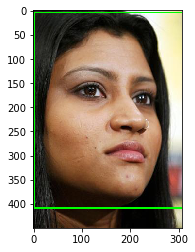

NO FIT


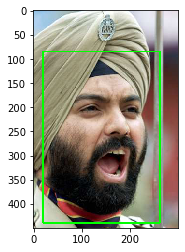

NO FIT


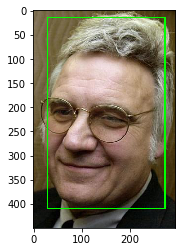

NO FIT


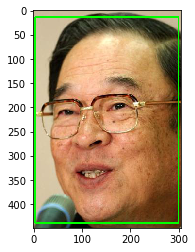

NO FIT


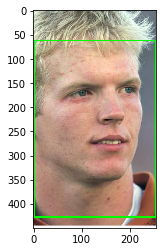

NO FIT


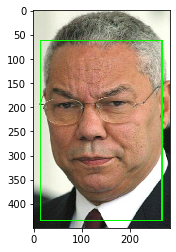

NO FIT


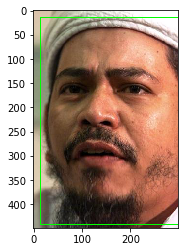

Showing fold: ./Faces/FDDB-folds/FDDB-fold-02-ellipseList.txt
NO FIT


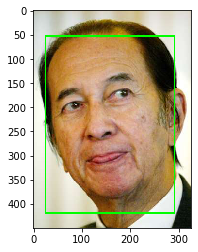

NO FIT


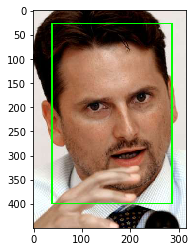

Showing fold: ./Faces/FDDB-folds/FDDB-fold-03-ellipseList.txt
NO FIT


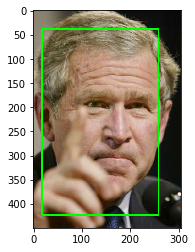

NO FIT


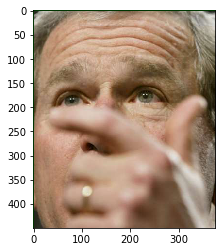

NO FIT


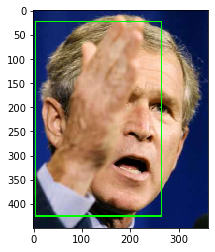

Showing fold: ./Faces/FDDB-folds/FDDB-fold-04-ellipseList.txt
NO FIT


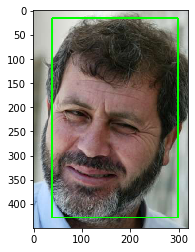

NO FIT


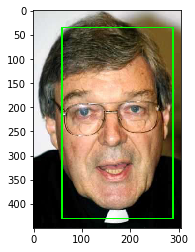

NO FIT


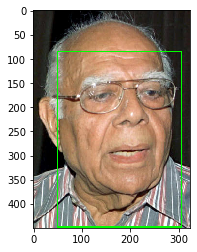

NO FIT


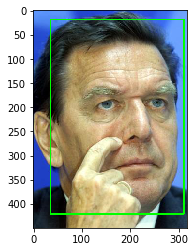

NO FIT


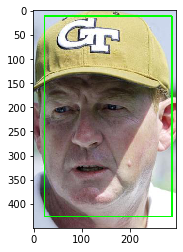

Showing fold: ./Faces/FDDB-folds/FDDB-fold-05-ellipseList.txt
NO FIT


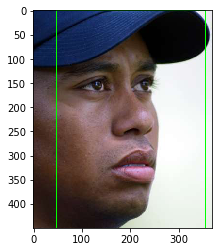

NO FIT


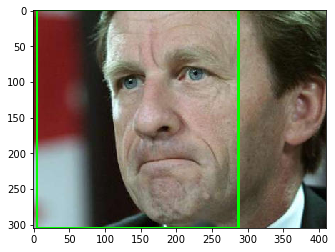

NO FIT


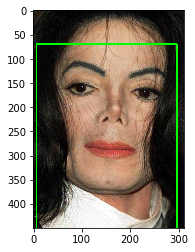

NO FIT


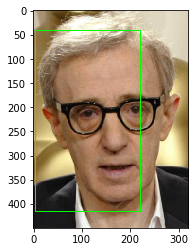

Showing fold: ./Faces/FDDB-folds/FDDB-fold-06-ellipseList.txt
NO FIT


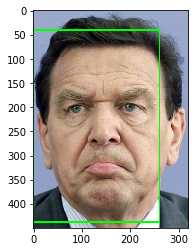

NO FIT


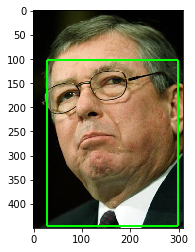

NO FIT


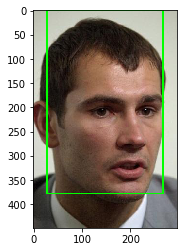

NO FIT


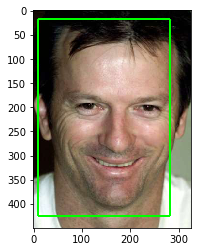

NO FIT


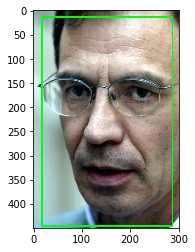

NO FIT


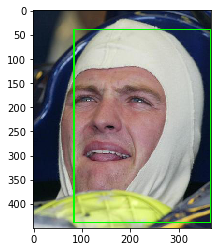

Showing fold: ./Faces/FDDB-folds/FDDB-fold-07-ellipseList.txt
NO FIT


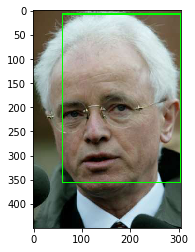

NO FIT


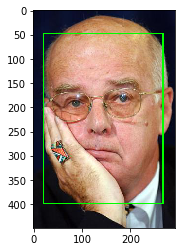

NO FIT


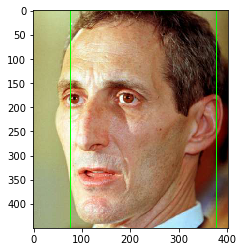

NO FIT


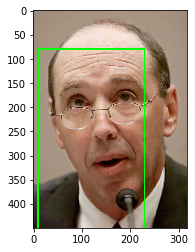

NO FIT


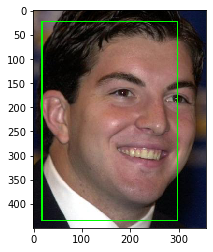

NO FIT


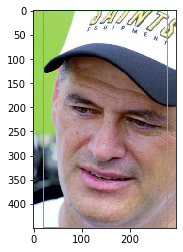

NO FIT


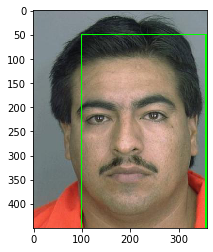

Showing fold: ./Faces/FDDB-folds/FDDB-fold-08-ellipseList.txt
NO FIT


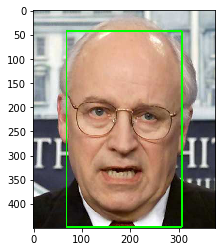

NO FIT


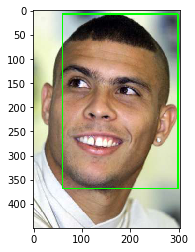

REMAINING CROPS:
[[3, 5, 307, 408], [20, 85, 262, 439], [29, 15, 271, 409], [4, 14, 299, 438], [3, 63, 251, 427], [15, 62, 265, 434], [15, 15, 299, 441], [25, 53, 291, 419], [39, 27, 287, 399], [18, 39, 258, 423], [0, 0, 377, 450], [5, 23, 265, 425], [39, 16, 299, 428], [59, 36, 289, 430], [50, 85, 306, 447], [36, 19, 311, 421], [23, 12, 286, 426], [48, 0, 355, 450], [5, 0, 287, 305], [7, 70, 296, 450], [5, 42, 221, 416], [0, 41, 260, 437], [28, 103, 298, 445], [28, 1, 268, 377], [10, 18, 282, 425], [18, 14, 287, 445], [84, 40, 366, 438], [60, 8, 304, 356], [21, 48, 267, 398], [77, 0, 379, 450], [10, 80, 230, 450], [18, 23, 298, 434], [21, 0, 277, 449], [100, 50, 356, 450], [68, 43, 306, 447], [61, 8, 299, 368]]


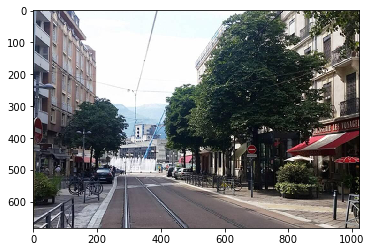

In [23]:


def main():
    root_path = "./Faces/"
    fold_path = root_path+"FDDB-folds/" ## FDDB-fold-01-ellipseList.txt
    img_path  = root_path+"originalPics/"
    
    
    id_true = 0
    id_neg  = 0
    
    
    #We store the negatives that did not fit in a buffer:
    negative_owed = []
    
    #Read amount of folders
    fold_amount = len([name for name in os.listdir(fold_path) if os.path.isfile(os.path.join(fold_path, name))])
    
    #cycle through all folders
    for fn in range(1,9):###int(fold_amount/2)+1):
        
        if fn < 10:
            fn = "0"+str(fn)
        else:
            fn = str(fn)
         
        #print("FOLDER: "+ fn)
        fold_path_tmp = fold_path + "FDDB-fold-" + fn + "-ellipseList.txt"
        print ("Showing fold: "+ fold_path_tmp)

        
        #Parse and create dictionary
        dict_annotations = H_parse_annotation(fold_path_tmp) 

        #
        dict_keys = list(dict_annotations.keys())

        #CYCLE THROUGH THE IMAGES IN THE FOLD LIST
        for img_id in range(len(dict_keys)-1):
        
            img_path_complete  = img_path+dict_keys[img_id]+".jpg"
            img = cv2.imread(img_path_complete)

            #print ("Showing Img: "+ dict_keys[img_id])
    
            img, rects, id_true    = Get_faces(img, dict_annotations[dict_keys[img_id]], id_true)
        
            img, new_owed, id_neg  = Create_empty(img, rects, id_neg)
            
            if len(new_owed) > 0:
                negative_owed += new_owed

                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.show()
        
    print("REMAINING CROPS:")
    print(negative_owed)
    if len(negative_owed)>0:
        img_path_filler  = img_path+"backdrop.jpg"
        img = cv2.imread(img_path_filler)
         
        img, new_owed,id_neg  = Create_empty(img, negative_owed,id_neg)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        
    

if __name__ == '__main__':
    main()           
